# Análisis específico de las preguntas de negocio

In [192]:
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as ss
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

In [193]:
%matplotlib inline
sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rcParams['figure.figsize'] = (11, 9.4)

In [194]:
df = pd.read_excel('./default of credit card clients.xls', header=1, index_col=0)

df['SEX'] = df['SEX'].map({ 
    1: 'Male', 
    2: 'Female', 
}).astype('category')
df['SEX'] = df['SEX'].cat.reorder_categories(['Male', 'Female'], ordered=True)


df['EDUCATION'] = df['EDUCATION'].map({
    1: 'Graduate School',
    2: 'University',
    3: 'High School',
    4: 'Others',
}).astype('category')
df['EDUCATION'] = df['EDUCATION'].fillna('Others')
df['EDUCATION'] = df['EDUCATION'].cat.reorder_categories(['Graduate School', 'University', 'High School', 'Others'], ordered=True)

df['MARRIAGE'] = df['MARRIAGE'].map({
    1: 'Married',
    2: 'Single',
    3: 'Others',
}).astype('category')
df['MARRIAGE'] = df['MARRIAGE'].fillna('Others')
df['MARRIAGE'] = df['MARRIAGE'].cat.reorder_categories(['Married', 'Single', 'Others'], ordered=True)

for pay_column in df.columns[5:11]:
    df[pay_column] = df[pay_column].map({
        -1: 'Paid ahead',
        0: 'Paid on time',
        1: 'Delay 1 Month',
        2: 'Delay 2 Months',
        3: 'Delay 3 Months',
        4: 'Delay 4 Months',
        5: 'Delay 5 Months',
        6: 'Delay 6 Months',
        7: 'Delay 7 Months',
        8: 'Delay 8 Months',
        9: 'Delay 9+ Months',
    })
    df[pay_column] = df[pay_column].fillna('New Customer')
    df[pay_column] = df[pay_column].astype('category').cat.set_categories([
        'New Customer',
        'Paid ahead',
        'Paid on time',
        'Delay 1 Month',
        'Delay 2 Months',
        'Delay 3 Months',
        'Delay 4 Months',
        'Delay 5 Months',
        'Delay 6 Months',
        'Delay 7 Months',
        'Delay 8 Months',
        'Delay 9+ Months',
    ], ordered=True)

df['default payment next month'] = df['default payment next month'].map({
    0: 'Not Defaulted',
    1: 'Defaulted',
}).astype('category')
df['default payment next month'] = df['default payment next month'].cat.reorder_categories(['Not Defaulted', 'Defaulted'], ordered=True)

df = df.rename(columns={
    'LIMIT_BAL': 'Credit Limit',
    'SEX': 'Sex',
    'EDUCATION': 'Education',
    'MARRIAGE': 'Marriage',
    'AGE': 'Age',
    'PAY_0': 'Payed Status in September',
    'PAY_2': 'Payed Status in August',
    'PAY_3': 'Payed Status in July',
    'PAY_4': 'Payed Status in June',
    'PAY_5': 'Payed Status in May',
    'PAY_6': 'Payed Status in April',
    'BILL_AMT1': 'Bill Amount in September',
    'BILL_AMT2': 'Bill Amount in August',
    'BILL_AMT3': 'Bill Amount in July',
    'BILL_AMT4': 'Bill Amount in June',
    'BILL_AMT5': 'Bill Amount in May',
    'BILL_AMT6': 'Bill Amount in April',
    'PAY_AMT1': 'Amount Paid in September',
    'PAY_AMT2': 'Amount Paid in August',
    'PAY_AMT3': 'Amount Paid in July',
    'PAY_AMT4': 'Amount Paid in June',
    'PAY_AMT5': 'Amount Paid in May',
    'PAY_AMT6': 'Amount Paid in April',
    'default payment next month': 'Defaulted Payment Next Month',
})

sex_color = {
    'Male': '#ff6602ff',
    'Female': '#0f7175ff'
}

education_color = {
    'Graduate School': '#ff6602ff',
    'University': '#0f7175ff',
    'High School': '#c65dc9ff',
    'Others': '#ffcc02ff'
}

marriage_color = {
    'Married': '#ff6602ff',
    'Single': '#0f7175ff',
    'Others': '#c65dc9ff'
}

payed_status_color = {
    'New Customer': '#6BAACF',
    'Paid on time': '#13ED0C',
    'Delay 1 Month': '#FFBA08',
    'Delay 2 Months': '#FAA307',
    'Delay 3 Months': '#F48C06',
    'Delay 4 Months': '#E85D04',
    'Delay 5 Months': '#DC2F02',
    'Delay 6 Months': '#D00000',
    'Delay 7 Months': '#9D0208',
    'Delay 8 Months': '#6A040F',
    'Delay 9+ Months': '#370617',
}

defaulted_color = {
    'Not Defaulted': '#91CB3E',
    'Defaulted': '#F1563B'
}

## ¿Cómo podemos utilizar el historial de pagos de los clientes en meses anteriores y su nivel de deuda para predecir qué clientes tienen mayor probabilidad de hacer default?

### Nuevos clientes

Realmente no se trata de nuevos clientes, si no de clientes que no tenían ninguna deuda en el mes anterior.

In [195]:
payed_status_columns = ['Payed Status in September', 'Payed Status in August', 'Payed Status in July', 'Payed Status in June', 'Payed Status in May', 'Payed Status in April'][::-1]
df[((df[payed_status_columns[1:]] == 'New Customer').any(axis=1)) & (df[payed_status_columns[0]] != 'New Customer')][['Bill Amount in April','Amount Paid in April', 'Payed Status in April', 'Bill Amount in May', 'Amount Paid in May', 'Payed Status in May', 'Bill Amount in June', 'Amount Paid in June', 'Payed Status in June', 'Bill Amount in July', 'Amount Paid in July', 'Payed Status in July', 'Bill Amount in August', 'Amount Paid in August', 'Payed Status in August', 'Bill Amount in September', 'Amount Paid in September', 'Payed Status in September', 'Defaulted Payment Next Month']].head(50)

,Bill Amount in April,Amount Paid in April,Payed Status in April,Bill Amount in May,Amount Paid in May,Payed Status in May,Bill Amount in June,Amount Paid in June,Payed Status in June,Bill Amount in July,Amount Paid in July,Payed Status in July,Bill Amount in August,Amount Paid in August,Payed Status in August,Bill Amount in September,Amount Paid in September,Payed Status in September,Defaulted Payment Next Month
ID,,,,,,,,,,,,,,,,,,,
10,13912,0,Paid ahead,13007,1122,Paid ahead,0,13007,New Customer,0,0,New Customer,0,0,New Customer,0,0,New Customer,Not Defaulted
27,-189,1000,Paid ahead,127,0,Paid ahead,-57,500,Paid ahead,259,0,Paid ahead,-425,1000,New Customer,-109,0,Delay 1 Month,Defaulted
36,-1884,0,Paid ahead,-1488,792,New Customer,-923,565,New Customer,-527,396,New Customer,-131,396,Paid ahead,30265,131,Paid ahead,Not Defaulted
65,0,0,Paid ahead,2353,0,Paid ahead,0,2353,New Customer,0,0,New Customer,0,0,Paid ahead,99,0,Paid ahead,Not Defaulted
66,7918,1000,Delay 2 Months,8198,0,Delay 2 Months,8174,300,Paid ahead,144076,8222,New Customer,148751,0,New Customer,152519,0,New Customer,Defaulted
69,7319,13899,Paid ahead,10161,7319,Delay 2 Months,10311,0,Paid ahead,-9850,20161,New Customer,-9850,0,New Customer,-190,0,Delay 1 Month,Not Defaulted
74,0,0,Paid ahead,2359,0,Paid ahead,0,2359,Paid ahead,3155,0,Paid ahead,0,3155,New Customer,0,0,Delay 1 Month,Not Defaulted
102,34056,5000,Paid on time,33564,1250,Paid on time,32891,1197,Paid on time,32475,1171,Paid ahead,-303,33178,New Customer,-81,223,New Customer,Not Defaulted
106,26529,2000,Paid ahead,0,26529,New Customer,0,0,New Customer,0,0,New Customer,0,0,Paid ahead,5580,0,Paid ahead,Not Defaulted


### Relación entre Credit Limit y Bill Amount

Hay 3931 clientes que superan el límite. No es un *hard limit*, pero suelen ser valores muy similares.

In [196]:
bill_amount_columns = ['Bill Amount in April', 'Bill Amount in May', 'Bill Amount in June', 'Bill Amount in July', 'Bill Amount in August', 'Bill Amount in September']
df[df.apply(lambda row: (row['Credit Limit'] < row[bill_amount_columns]).any(), axis=1)][bill_amount_columns + ['Credit Limit']].head(50)

,Bill Amount in April,Bill Amount in May,Bill Amount in June,Bill Amount in July,Bill Amount in August,Bill Amount in September,Credit Limit
ID,,,,,,,
6,20024,19619,19394,57608,57069,64400,50000
7,473944,483003,542653,445007,412023,367965,500000
16,30211,29531,28771,28116,29173,50614,50000
41,179224,195969,628699,206895,221296,218668,360000
50,20063,20480,19865,19476,18479,17447,20000
60,364089,356656,360199,404205,398857,400134,400000
62,830,14096,16518,69938,72060,70800,70000
79,6411,26446,28004,30326,29612,28387,30000
103,469961,471145,487066,479432,431342,422069,480000


### Relación entre Bill Amount, Amount Paid y Payed Status

In [197]:
df[['Bill Amount in April','Amount Paid in April', 'Payed Status in April', 'Bill Amount in May', 'Amount Paid in May', 'Payed Status in May', 'Bill Amount in June', 'Amount Paid in June', 'Payed Status in June', 'Bill Amount in July', 'Amount Paid in July', 'Payed Status in July', 'Bill Amount in August', 'Amount Paid in August', 'Payed Status in August', 'Bill Amount in September', 'Amount Paid in September', 'Payed Status in September', 'Defaulted Payment Next Month']].head(50)

,Bill Amount in April,Amount Paid in April,Payed Status in April,Bill Amount in May,Amount Paid in May,Payed Status in May,Bill Amount in June,Amount Paid in June,Payed Status in June,Bill Amount in July,Amount Paid in July,Payed Status in July,Bill Amount in August,Amount Paid in August,Payed Status in August,Bill Amount in September,Amount Paid in September,Payed Status in September,Defaulted Payment Next Month
ID,,,,,,,,,,,,,,,,,,,
1,0,0,New Customer,0,0,New Customer,0,0,Paid ahead,689,0,Paid ahead,3102,689,Delay 2 Months,3913,0,Delay 2 Months,Defaulted
2,3261,2000,Delay 2 Months,3455,0,Paid on time,3272,1000,Paid on time,2682,1000,Paid on time,1725,1000,Delay 2 Months,2682,0,Paid ahead,Defaulted
3,15549,5000,Paid on time,14948,1000,Paid on time,14331,1000,Paid on time,13559,1000,Paid on time,14027,1500,Paid on time,29239,1518,Paid on time,Not Defaulted
4,29547,1000,Paid on time,28959,1069,Paid on time,28314,1100,Paid on time,49291,1200,Paid on time,48233,2019,Paid on time,46990,2000,Paid on time,Not Defaulted
5,19131,679,Paid on time,19146,689,Paid on time,20940,9000,Paid on time,35835,10000,Paid ahead,5670,36681,Paid on time,8617,2000,Paid ahead,Not Defaulted
6,20024,800,Paid on time,19619,1000,Paid on time,19394,1000,Paid on time,57608,657,Paid on time,57069,1815,Paid on time,64400,2500,Paid on time,Not Defaulted
7,473944,13770,Paid on time,483003,13750,Paid on time,542653,20239,Paid on time,445007,38000,Paid on time,412023,40000,Paid on time,367965,55000,Paid on time,Not Defaulted
8,567,1542,Paid ahead,-159,1687,Paid on time,221,581,Paid on time,601,0,Paid ahead,380,601,Paid ahead,11876,380,Paid on time,Not Defaulted
9,3719,1000,Paid on time,11793,1000,Paid on time,12211,1000,Paid on time,12108,432,Delay 2 Months,14096,0,Paid on time,11285,3329,Paid on time,Not Defaulted


In [198]:
df['Expenses in May'] = df['Bill Amount in May'] - df['Bill Amount in April'] + df['Amount Paid in May']
df['Expenses in June'] = df['Bill Amount in June'] - df['Bill Amount in May'] + df['Amount Paid in June']
df['Expenses in July'] = df['Bill Amount in July'] - df['Bill Amount in June'] + df['Amount Paid in July']
df['Expenses in August'] = df['Bill Amount in August'] - df['Bill Amount in July'] + df['Amount Paid in August']
df['Expenses in September'] = df['Bill Amount in September'] - df['Bill Amount in August'] + df['Amount Paid in September']
expenses_columns = ['Expenses in May', 'Expenses in June', 'Expenses in July', 'Expenses in August', 'Expenses in September']
df[expenses_columns].describe()

,Expenses in May,Expenses in June,Expenses in July,Expenses in August,Expenses in September
count,30000.000000,30000.000000,3.000000e+04,3.000000e+04,30000.000000
mean,6239.028200,7777.624867,8.975887e+03,8.087084e+03,7707.836233
std,18099.675244,20743.418399,2.552261e+04,2.365755e+04,21681.701261
min,-315869.000000,-250735.000000,-4.158040e+05,-3.266700e+05,-294239.000000
25%,390.000000,396.000000,5.007500e+02,5.730000e+02,613.750000
50%,1412.000000,1617.000000,1.966000e+03,2.069000e+03,2069.000000
75%,5104.000000,6440.500000,7.621000e+03,6.970250e+03,6538.750000
max,447736.000000,621570.000000,1.664163e+06,1.357812e+06,836617.000000


In [199]:
print("Hay", df[(df[expenses_columns] < 0).any(axis=1)].shape[0], "registros con gastos negativos")

Hay 612 registros con gastos negativos


In [200]:
df[(df[expenses_columns] < 0).any(axis=1)][['Bill Amount in April', 'Amount Paid in May', 'Expenses in May', 'Bill Amount in May', 'Amount Paid in June', 'Expenses in June', 'Bill Amount in June', 'Amount Paid in July', 'Expenses in July', 'Bill Amount in July', 'Amount Paid in August', 'Expenses in August', 'Bill Amount in August', 'Amount Paid in September', 'Expenses in September', 'Bill Amount in September', 'Defaulted Payment Next Month']].head(50)

,Bill Amount in April,Amount Paid in May,Expenses in May,Bill Amount in May,Amount Paid in June,Expenses in June,Bill Amount in June,Amount Paid in July,Expenses in July,Bill Amount in July,Amount Paid in August,Expenses in August,Bill Amount in August,Amount Paid in September,Expenses in September,Bill Amount in September,Defaulted Payment Next Month
ID,,,,,,,,,,,,,,,,,
7,473944,13750,22809,483003,20239,79889,542653,38000,-59646,445007,40000,7016,412023,55000,10942,367965,Not Defaulted
41,179224,28000,44745,195969,188840,621570,628699,6000,-415804,206895,7000,21401,221296,10000,7372,218668,Not Defaulted
142,416,3500,3500,416,500,416,332,332,832,832,416,-416,0,0,1832,1832,Not Defaulted
215,309959,10838,6024,305145,10484,185317,479978,0,-172135,307843,11001,6478,303320,13000,6253,296573,Not Defaulted
304,12510,1000,4251,15761,1700,1763,15824,4000,15996,27820,0,-13256,14564,2800,204,11968,Defaulted
493,69174,2003,1329,68500,2003,42227,108724,207,113585,222102,11900,-109222,100980,4000,1580,98560,Not Defaulted
498,19664,1113,11639,30190,1025,-10317,18848,820,305,18333,0,2084,20417,7403,3426,16440,Not Defaulted
578,4085,4085,538,538,0,3544,4082,4082,8308,8308,8314,32229,32223,13647,-12582,5994,Not Defaulted
593,9011,4383,1392,6020,249,1335,7106,215,7039,13930,1074,-6838,6018,1127,30085,34976,Not Defaulted


In [201]:
# Si los expenses son menores a 0, definirlos como 0 y ajustar el Amount Paid
months = ['April', 'May', 'June', 'July', 'August', 'September']
for i, month in enumerate(months[1:]):
    df.loc[df[expenses_columns[i]] < 0, 'Amount Paid in ' + month] = df.loc[df[expenses_columns[i]] < 0, 'Amount Paid in ' + month] - df.loc[df[expenses_columns[i]] < 0, expenses_columns[i]]
    df.loc[df[expenses_columns[i]] < 0, expenses_columns[i]] = 0

df.loc[[7,41,142,215,304,493]][['Bill Amount in April', 'Amount Paid in May', 'Expenses in May', 'Bill Amount in May', 'Amount Paid in June', 'Expenses in June', 'Bill Amount in June', 'Amount Paid in July', 'Expenses in July', 'Bill Amount in July', 'Amount Paid in August', 'Expenses in August', 'Bill Amount in August', 'Amount Paid in September', 'Expenses in September', 'Bill Amount in September', 'Defaulted Payment Next Month']]

,Bill Amount in April,Amount Paid in May,Expenses in May,Bill Amount in May,Amount Paid in June,Expenses in June,Bill Amount in June,Amount Paid in July,Expenses in July,Bill Amount in July,Amount Paid in August,Expenses in August,Bill Amount in August,Amount Paid in September,Expenses in September,Bill Amount in September,Defaulted Payment Next Month
ID,,,,,,,,,,,,,,,,,
7,473944,13750,22809,483003,20239,79889,542653,97646,0,445007,40000,7016,412023,55000,10942,367965,Not Defaulted
41,179224,28000,44745,195969,188840,621570,628699,421804,0,206895,7000,21401,221296,10000,7372,218668,Not Defaulted
142,416,3500,3500,416,500,416,332,332,832,832,832,0,0,0,1832,1832,Not Defaulted
215,309959,10838,6024,305145,10484,185317,479978,172135,0,307843,11001,6478,303320,13000,6253,296573,Not Defaulted
304,12510,1000,4251,15761,1700,1763,15824,4000,15996,27820,13256,0,14564,2800,204,11968,Defaulted
493,69174,2003,1329,68500,2003,42227,108724,207,113585,222102,121122,0,100980,4000,1580,98560,Not Defaulted


<Axes: >

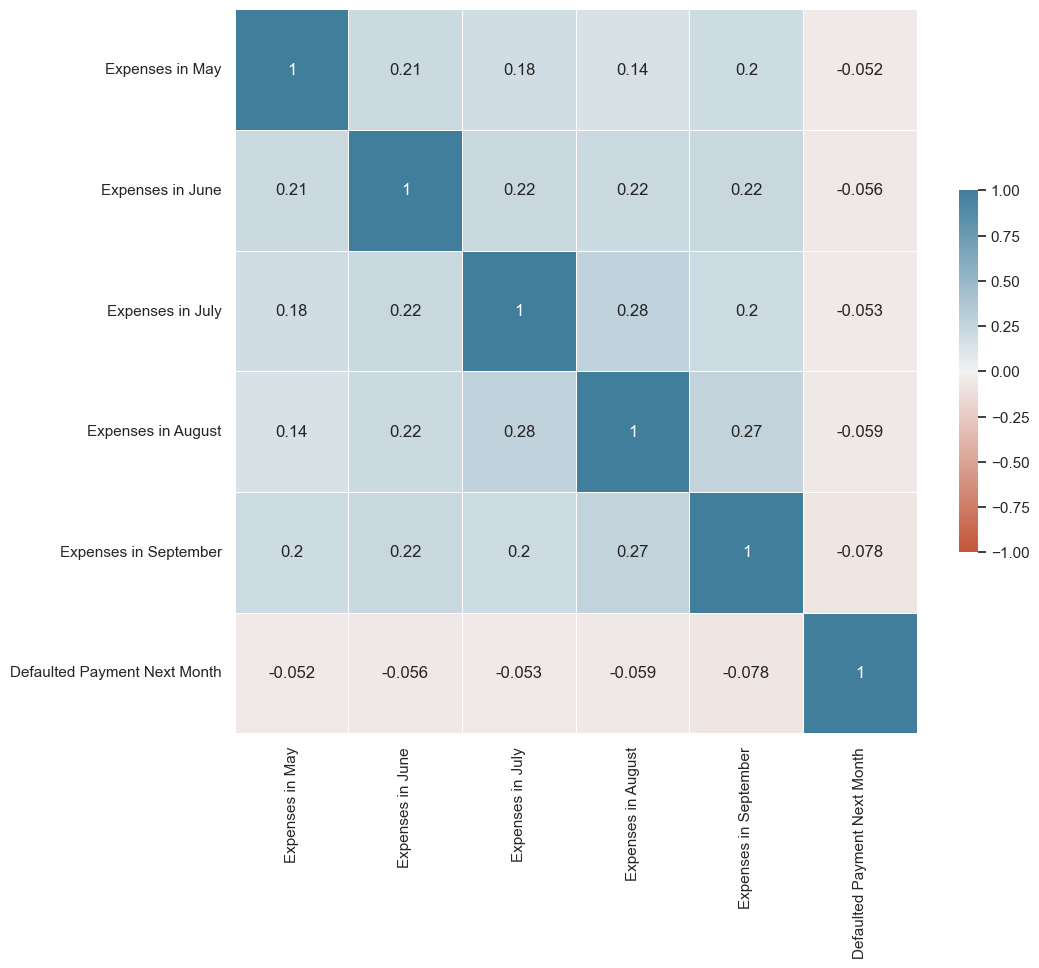

In [202]:
temp_df = df[expenses_columns + ['Defaulted Payment Next Month']].copy()
temp_df['Defaulted Payment Next Month'] = temp_df['Defaulted Payment Next Month'].map({ 'Not Defaulted': 0, 'Defaulted': 1 }).astype(int)
sns.heatmap(
    data=temp_df.corr(numeric_only=True),
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True
)

### Regresión de variables dado su valor en el mes anterior

In [203]:
def analyse_subsequent_months_behavior(df, column_prefix, include_target=False):

    prev_months_list = ['April', 'May', 'June', 'July', 'August'] + (['September'] if include_target else [])
    next_months_list = ['May', 'June', 'July', 'August', 'September'] + (['October'] if include_target else [])


    prev_month = pd.concat([temp_df[f"{column_prefix}{month}"] for month in prev_months_list], axis=0)
    next_month = pd.concat([temp_df[f"{column_prefix}{month}"] for month in next_months_list], axis=0)
    regression_df = pd.DataFrame({
        'prev_month': prev_month,
        'next_month': next_month,
    })

    reg_model = (
        smf.ols(
            formula='next_month ~ prev_month',
            data=regression_df
        )
        .fit()
    )
    return reg_model


print("Análisis para Payed Status")
print("*"*100)
temp_df = df.copy()
temp_df['Payed Status in April'] = (temp_df['Payed Status in April'].isin(['New Customer', 'Paid ahead', 'Paid on time'])).astype(int)
temp_df['Payed Status in May'] = (temp_df['Payed Status in May'].isin(['New Customer', 'Paid ahead', 'Paid on time'])).astype(int)
temp_df['Payed Status in June'] = (temp_df['Payed Status in June'].isin(['New Customer', 'Paid ahead', 'Paid on time'])).astype(int)
temp_df['Payed Status in July'] = (temp_df['Payed Status in July'].isin(['New Customer', 'Paid ahead', 'Paid on time'])).astype(int)
temp_df['Payed Status in August'] = (temp_df['Payed Status in August'].isin(['New Customer', 'Paid ahead', 'Paid on time'])).astype(int)
temp_df['Payed Status in September'] = (temp_df['Payed Status in September'].isin(['New Customer', 'Paid ahead', 'Paid on time'])).astype(int)
temp_df['Payed Status in October'] = temp_df['Defaulted Payment Next Month'].map({ 'Not Defaulted': 1, 'Defaulted': 0 }).astype(int)
print("Sin considerar la variable objetivo")
print(analyse_subsequent_months_behavior(temp_df, 'Payed Status in ', include_target=False).summary())
print("*"*100)
print("Considerando la variable objetivo")
print(analyse_subsequent_months_behavior(temp_df, 'Payed Status in ', include_target=True).summary())

Análisis para Payed Status
****************************************************************************************************
Sin considerar la variable objetivo
                            OLS Regression Results                            
Dep. Variable:             next_month   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                 1.084e+05
Date:                Wed, 08 May 2024   Prob (F-statistic):               0.00
Time:                        23:52:39   Log-Likelihood:                -16030.
No. Observations:              150000   AIC:                         3.206e+04
Df Residuals:                  149998   BIC:                         3.208e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t   

In [204]:
print("Análisis para Bill Amount")
print("*"*100)
temp_df = df.copy()
print(analyse_subsequent_months_behavior(temp_df, 'Bill Amount in ', include_target=False).summary())

Análisis para Bill Amount
****************************************************************************************************
                            OLS Regression Results                            
Dep. Variable:             next_month   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                 1.096e+06
Date:                Wed, 08 May 2024   Prob (F-statistic):               0.00
Time:                        23:52:39   Log-Likelihood:            -1.7234e+06
No. Observations:              150000   AIC:                         3.447e+06
Df Residuals:                  149998   BIC:                         3.447e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

In [205]:
print("Análisis para Amount Paid")
print("*"*100)
temp_df = df.copy()
print(analyse_subsequent_months_behavior(temp_df, 'Amount Paid in ', include_target=False).summary())

Análisis para Amount Paid
****************************************************************************************************
                            OLS Regression Results                            
Dep. Variable:             next_month   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     6870.
Date:                Wed, 08 May 2024   Prob (F-statistic):               0.00
Time:                        23:52:39   Log-Likelihood:            -1.6820e+06
No. Observations:              150000   AIC:                         3.364e+06
Df Residuals:                  149998   BIC:                         3.364e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

In [206]:
temp_df = df.copy()
time_df = pd.DataFrame({
    "Credit Limit": temp_df["Credit Limit"].repeat(6),
    "Sex": temp_df['Sex'].repeat(6),
    "Education": temp_df['Education'].repeat(6),
    "Marriage": temp_df['Marriage'].repeat(6),
    "Age": temp_df['Age'].repeat(6),
    "Month": ['April', 'May', 'June', 'July', 'August', 'September'] * temp_df.shape[0],
    "Payed Status": temp_df[['Payed Status in April', 'Payed Status in May', 'Payed Status in June', 'Payed Status in July', 'Payed Status in August', 'Payed Status in September']].values.flatten(),
    "Bill Amount": temp_df[['Bill Amount in April', 'Bill Amount in May', 'Bill Amount in June', 'Bill Amount in July', 'Bill Amount in August', 'Bill Amount in September']].values.flatten(),
    "Amount Paid": temp_df[['Amount Paid in April', 'Amount Paid in May', 'Amount Paid in June', 'Amount Paid in July', 'Amount Paid in August', 'Amount Paid in September']].values.flatten(),
    "Defaulted Payment October": temp_df['Defaulted Payment Next Month'].repeat(6),
})
time_df.head(6*5)

,Credit Limit,Sex,Education,Marriage,Age,Month,Payed Status,Bill Amount,Amount Paid,Defaulted Payment October
ID,,,,,,,,,,
1,20000,Female,University,Married,24,April,New Customer,0,0,Defaulted
1,20000,Female,University,Married,24,May,New Customer,0,0,Defaulted
1,20000,Female,University,Married,24,June,Paid ahead,0,0,Defaulted
1,20000,Female,University,Married,24,July,Paid ahead,689,0,Defaulted
1,20000,Female,University,Married,24,August,Delay 2 Months,3102,689,Defaulted
1,20000,Female,University,Married,24,September,Delay 2 Months,3913,0,Defaulted
2,120000,Female,University,Single,26,April,Delay 2 Months,3261,2000,Defaulted
2,120000,Female,University,Single,26,May,Paid on time,3455,0,Defaulted
2,120000,Female,University,Single,26,June,Paid on time,3272,1000,Defaulted


<Axes: >

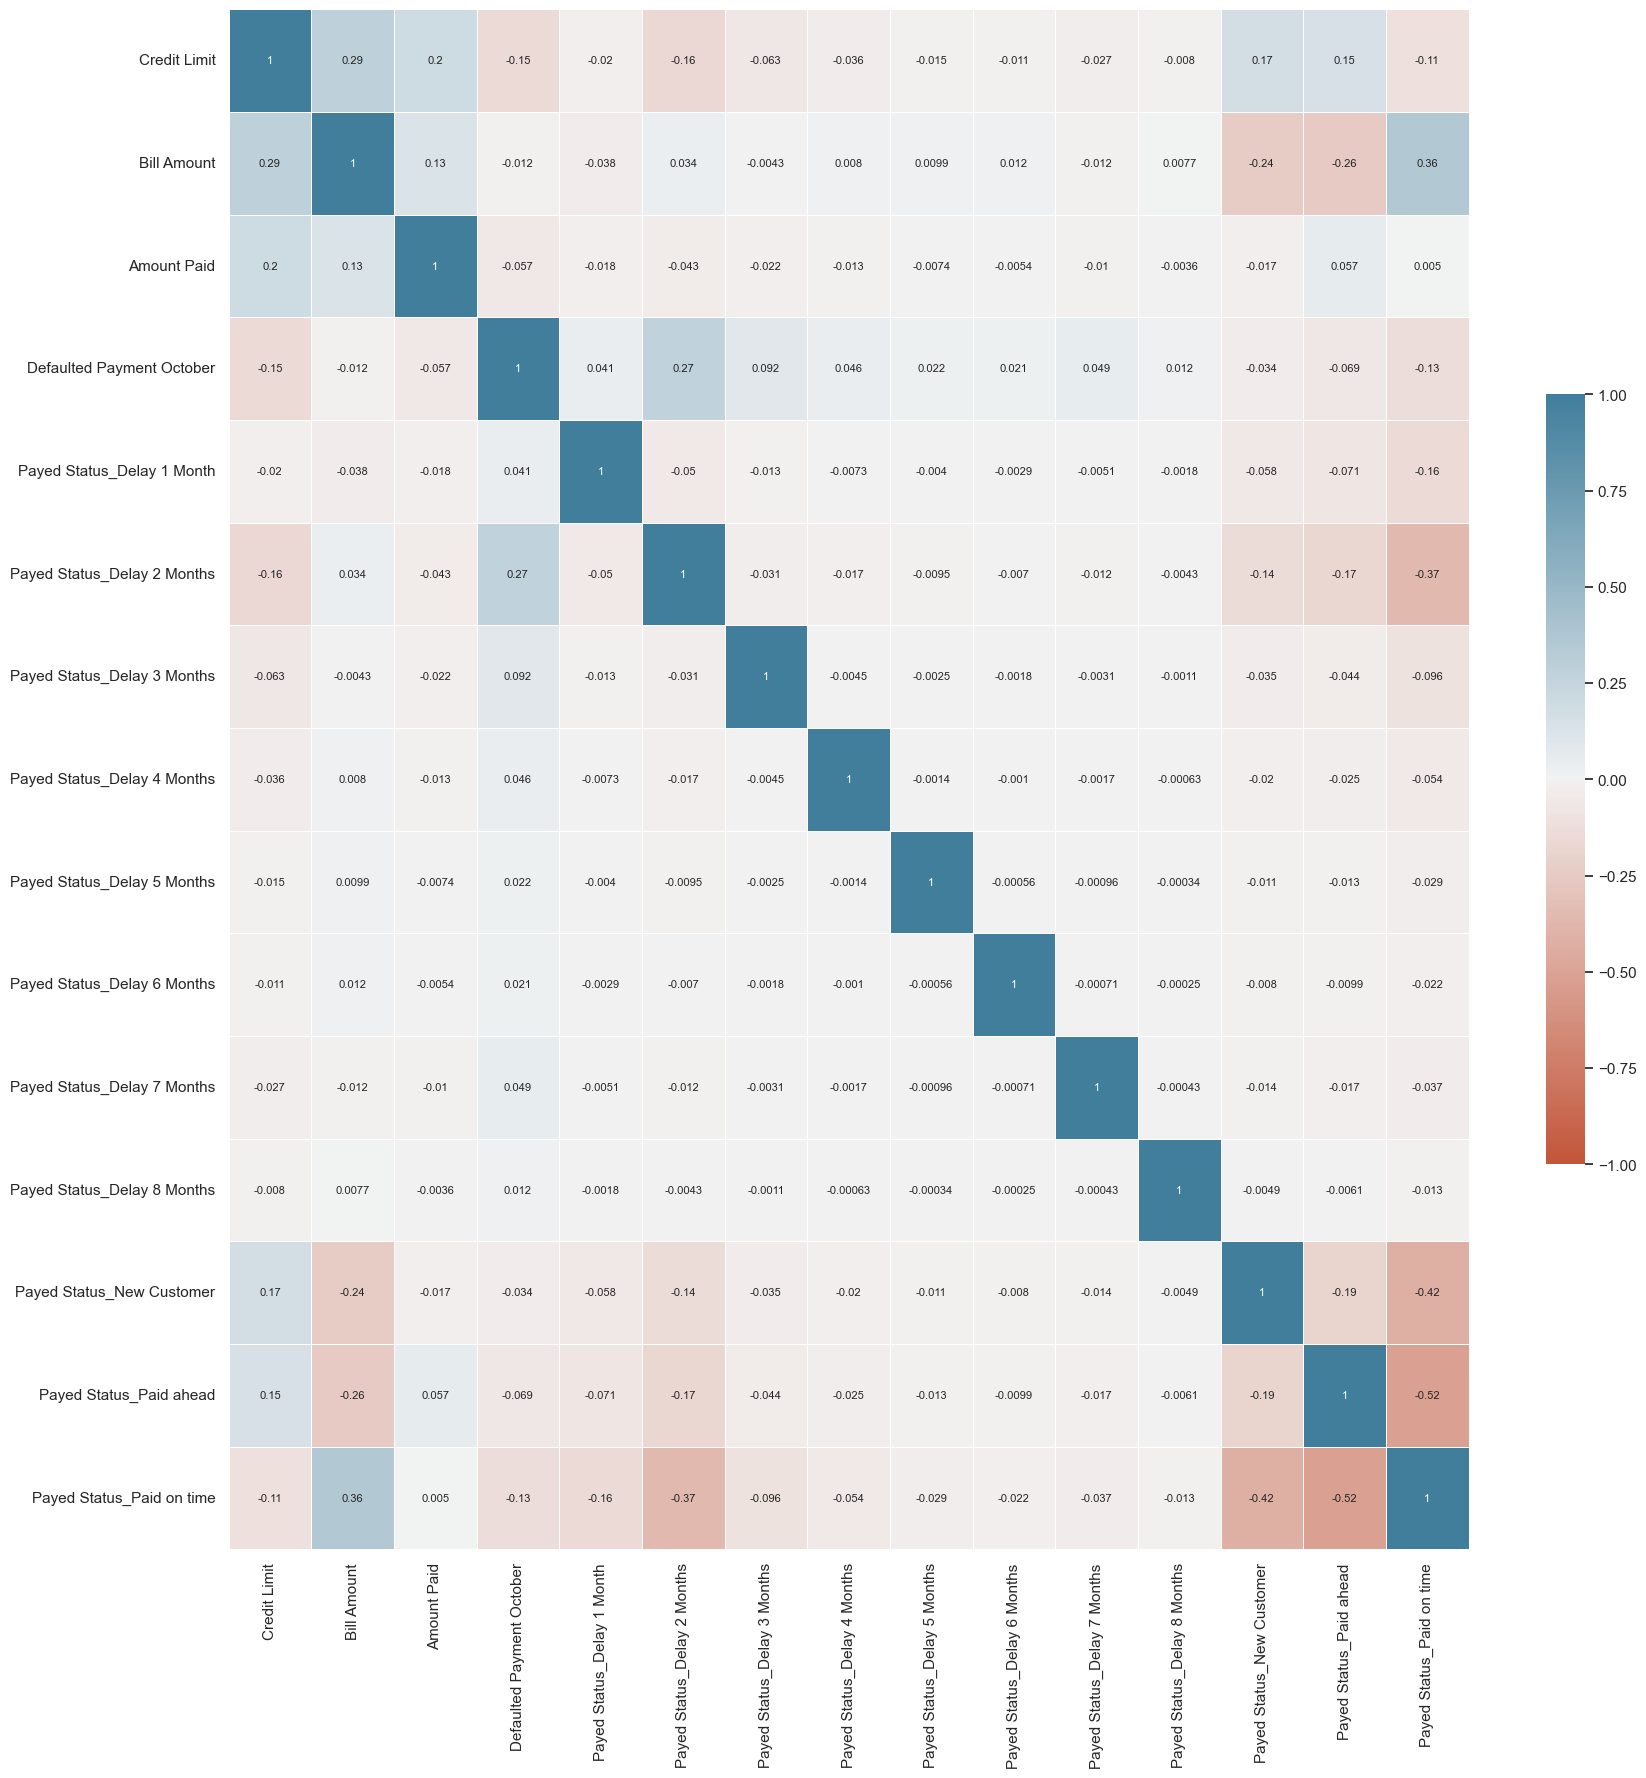

In [207]:
temp_df = time_df.copy().drop(columns=['Month', 'Sex', 'Education', 'Marriage', 'Age'])
temp_df['Defaulted Payment October'] = temp_df['Defaulted Payment October'].map({ 'Not Defaulted': 0, 'Defaulted': 1 }).astype(int)
temp_df = pd.get_dummies(temp_df)
plt.figure(figsize=(20, 20))
sns.heatmap(
    data=temp_df.corr(),
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    annot_kws={"size": 8}
)


In [208]:
temp_df = df.copy()
time_df = pd.DataFrame({
    "Credit Limit": temp_df["Credit Limit"].repeat(5),
    "Sex": temp_df['Sex'].repeat(5),
    "Education": temp_df['Education'].repeat(5),
    "Marriage": temp_df['Marriage'].repeat(5),
    "Age": temp_df['Age'].repeat(5),
    "Month Prev": ['April', 'May', 'June', 'July', 'August'] * temp_df.shape[0],
    "Month Next": ['May', 'June', 'July', 'August', 'September'] * temp_df.shape[0],
    "Payed Status Prev": temp_df[['Payed Status in April', 'Payed Status in May', 'Payed Status in June', 'Payed Status in July', 'Payed Status in August']].values.flatten(),
    "Payed Status Next": temp_df[['Payed Status in May', 'Payed Status in June', 'Payed Status in July', 'Payed Status in August', 'Payed Status in September']].values.flatten(),
    "Bill Amount Prev": temp_df[['Bill Amount in April', 'Bill Amount in May', 'Bill Amount in June', 'Bill Amount in July', 'Bill Amount in August']].values.flatten(),
    "Bill Amount Next": temp_df[['Bill Amount in May', 'Bill Amount in June', 'Bill Amount in July', 'Bill Amount in August', 'Bill Amount in September']].values.flatten(),
    "Amount Paid Prev": temp_df[['Amount Paid in April', 'Amount Paid in May', 'Amount Paid in June', 'Amount Paid in July', 'Amount Paid in August']].values.flatten(),
    "Amount Paid Next": temp_df[['Amount Paid in May', 'Amount Paid in June', 'Amount Paid in July', 'Amount Paid in August', 'Amount Paid in September']].values.flatten(),
    "Defaulted Payment October": temp_df['Defaulted Payment Next Month'].repeat(5),
})
time_df.head(5*5)

,Credit Limit,Sex,Education,Marriage,Age,Month Prev,Month Next,Payed Status Prev,Payed Status Next,Bill Amount Prev,Bill Amount Next,Amount Paid Prev,Amount Paid Next,Defaulted Payment October
ID,,,,,,,,,,,,,,
1,20000,Female,University,Married,24,April,May,New Customer,New Customer,0,0,0,0,Defaulted
1,20000,Female,University,Married,24,May,June,New Customer,Paid ahead,0,0,0,0,Defaulted
1,20000,Female,University,Married,24,June,July,Paid ahead,Paid ahead,0,689,0,0,Defaulted
1,20000,Female,University,Married,24,July,August,Paid ahead,Delay 2 Months,689,3102,0,689,Defaulted
1,20000,Female,University,Married,24,August,September,Delay 2 Months,Delay 2 Months,3102,3913,689,0,Defaulted
2,120000,Female,University,Single,26,April,May,Delay 2 Months,Paid on time,3261,3455,2000,0,Defaulted
2,120000,Female,University,Single,26,May,June,Paid on time,Paid on time,3455,3272,0,1000,Defaulted
2,120000,Female,University,Single,26,June,July,Paid on time,Paid on time,3272,2682,1000,1000,Defaulted
2,120000,Female,University,Single,26,July,August,Paid on time,Delay 2 Months,2682,1725,1000,1000,Defaulted


### Heatmap de la evolución del historial de pagos

<Axes: >

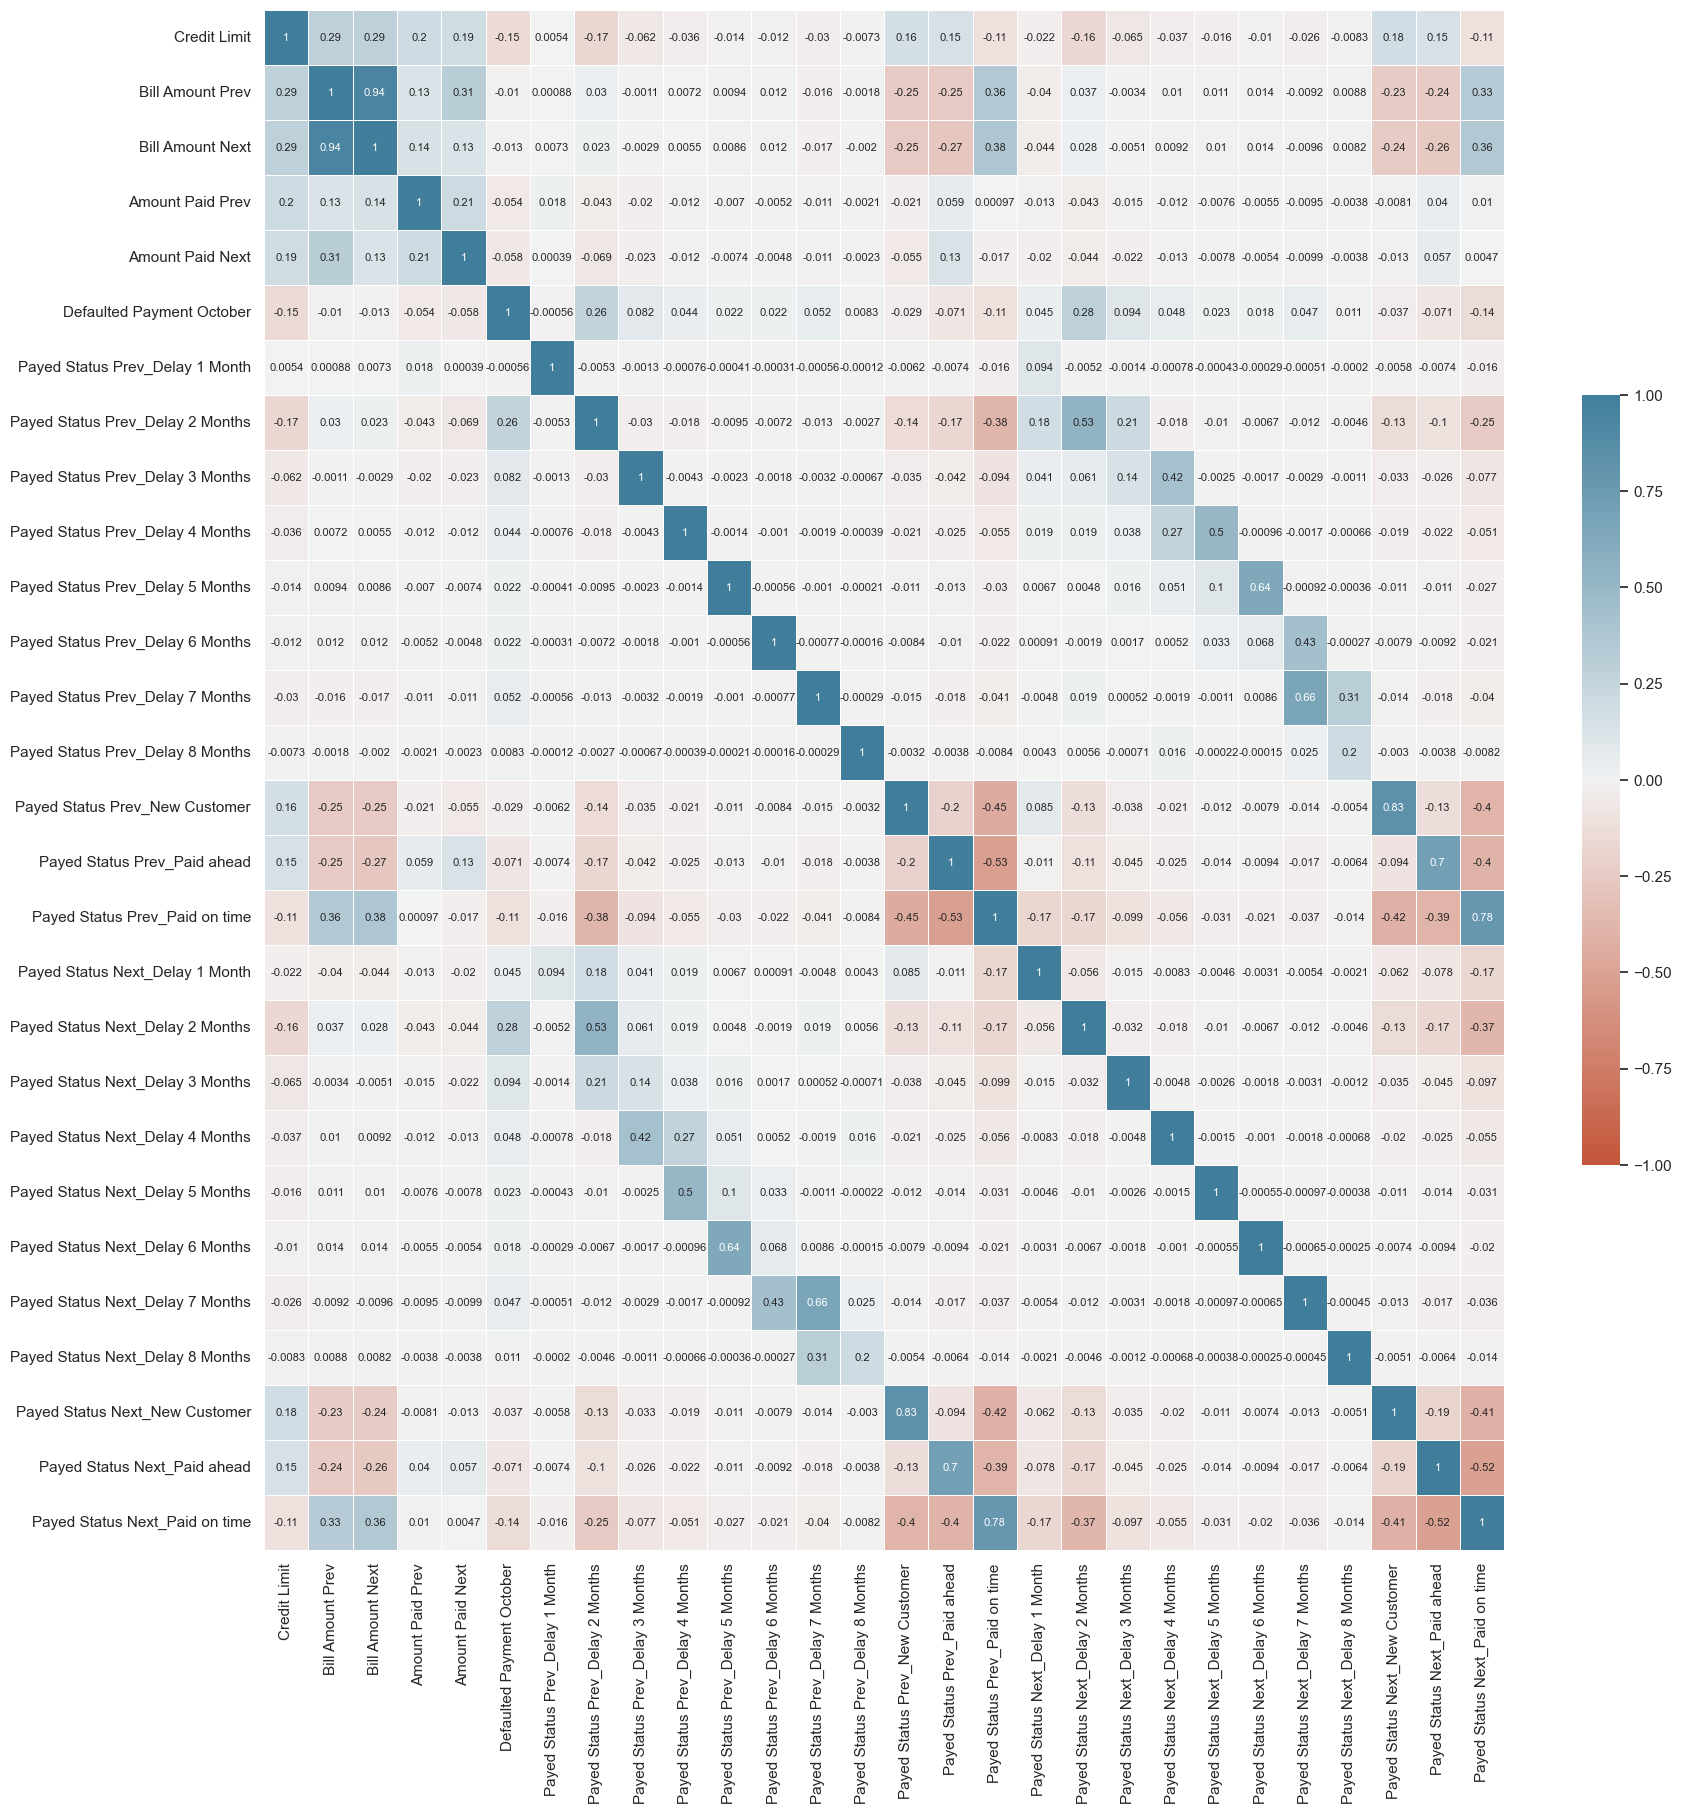

In [209]:
temp_df = time_df.copy().drop(columns=['Month Prev', 'Month Next', 'Sex', 'Education', 'Marriage', 'Age'])
temp_df['Defaulted Payment October'] = temp_df['Defaulted Payment October'].map({ 'Not Defaulted': 0, 'Defaulted': 1 }).astype(int)
temp_df = pd.get_dummies(temp_df)
plt.figure(figsize=(20, 20))
sns.heatmap(
    data=temp_df.corr(),
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    annot_kws={"size": 8}
)

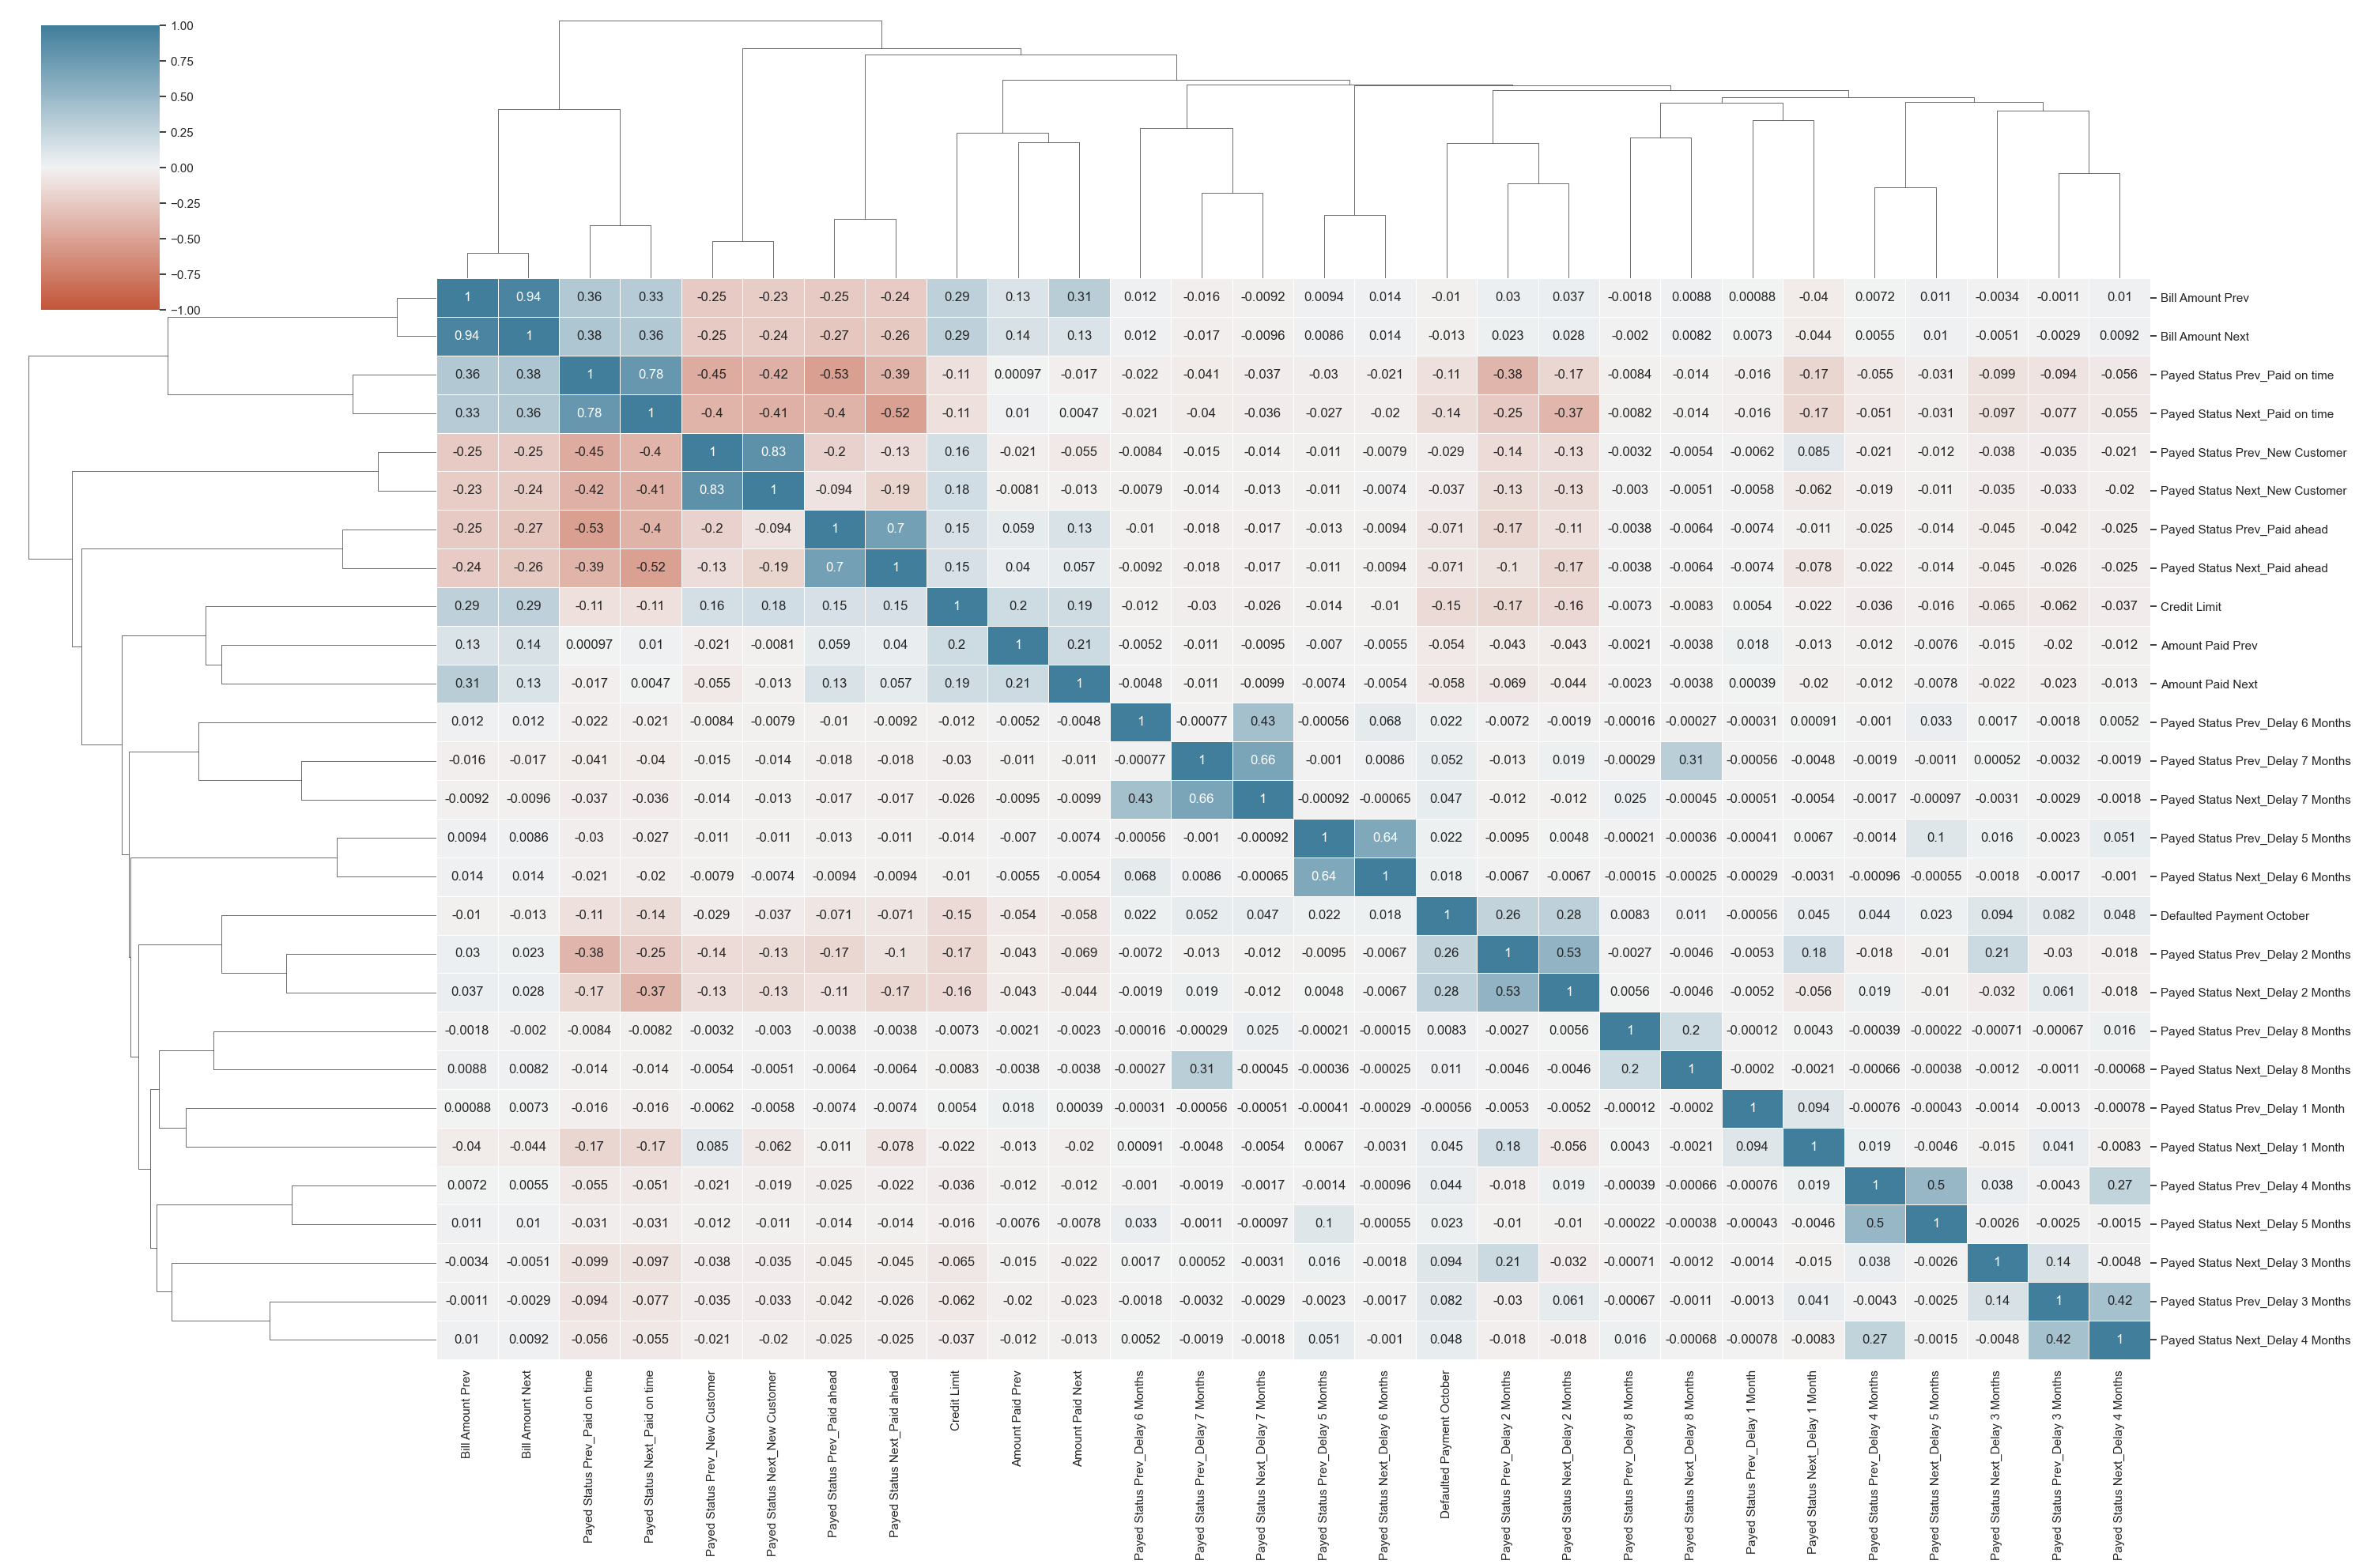

In [210]:
sns.clustermap(
    figsize=(30, 20),
    data=temp_df.corr(numeric_only=True),
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True
)

In [211]:
temp_df = df.copy()
temp_df['Expenses in May'] = temp_df['Bill Amount in May'] - temp_df['Bill Amount in April'] + temp_df['Amount Paid in May']
temp_df['Expenses in June'] = temp_df['Bill Amount in June'] - temp_df['Bill Amount in May'] + temp_df['Amount Paid in June']
temp_df['Expenses in July'] = temp_df['Bill Amount in July'] - temp_df['Bill Amount in June'] + temp_df['Amount Paid in July']
temp_df['Expenses in August'] = temp_df['Bill Amount in August'] - temp_df['Bill Amount in July'] + temp_df['Amount Paid in August']
temp_df['Expenses in September'] = temp_df['Bill Amount in September'] - temp_df['Bill Amount in August'] + temp_df['Amount Paid in September']

time_df = pd.DataFrame({
    "Credit Limit": temp_df["Credit Limit"].repeat(4),
    "Sex": temp_df['Sex'].repeat(4),
    "Education": temp_df['Education'].repeat(4),
    "Marriage": temp_df['Marriage'].repeat(4),
    "Age": temp_df['Age'].repeat(4),
    "Month Prev": ['May', 'June', 'July', 'August'] * temp_df.shape[0],
    "Month Next": ['June', 'July', 'August', 'September'] * temp_df.shape[0],
    "Payed Status Prev": temp_df[['Payed Status in May', 'Payed Status in June', 'Payed Status in July', 'Payed Status in August']].values.flatten(),
    "Payed Status Next": temp_df[['Payed Status in June', 'Payed Status in July', 'Payed Status in August', 'Payed Status in September']].values.flatten(),
    "Bill Amount Prev": temp_df[['Bill Amount in May', 'Bill Amount in June', 'Bill Amount in July', 'Bill Amount in August']].values.flatten(),
    "Bill Amount Next": temp_df[['Bill Amount in June', 'Bill Amount in July', 'Bill Amount in August', 'Bill Amount in September']].values.flatten(),
    "Amount Paid Prev": temp_df[['Amount Paid in May', 'Amount Paid in June', 'Amount Paid in July', 'Amount Paid in August']].values.flatten(),
    "Amount Paid Next": temp_df[['Amount Paid in June', 'Amount Paid in July', 'Amount Paid in August', 'Amount Paid in September']].values.flatten(),
    "Expenses Prev": temp_df[['Expenses in May', 'Expenses in June', 'Expenses in July', 'Expenses in August']].values.flatten(),
    "Expenses Next": temp_df[['Expenses in June', 'Expenses in July', 'Expenses in August', 'Expenses in September']].values.flatten(),
    "Defaulted Payment October": temp_df['Defaulted Payment Next Month'].repeat(4),
})
time_df.head(4*5)

,Credit Limit,Sex,Education,Marriage,Age,Month Prev,Month Next,Payed Status Prev,Payed Status Next,Bill Amount Prev,Bill Amount Next,Amount Paid Prev,Amount Paid Next,Expenses Prev,Expenses Next,Defaulted Payment October
ID,,,,,,,,,,,,,,,,
1,20000,Female,University,Married,24,May,June,New Customer,Paid ahead,0,0,0,0,0,0,Defaulted
1,20000,Female,University,Married,24,June,July,Paid ahead,Paid ahead,0,689,0,0,0,689,Defaulted
1,20000,Female,University,Married,24,July,August,Paid ahead,Delay 2 Months,689,3102,0,689,689,3102,Defaulted
1,20000,Female,University,Married,24,August,September,Delay 2 Months,Delay 2 Months,3102,3913,689,0,3102,811,Defaulted
2,120000,Female,University,Single,26,May,June,Paid on time,Paid on time,3455,3272,0,1000,194,817,Defaulted
2,120000,Female,University,Single,26,June,July,Paid on time,Paid on time,3272,2682,1000,1000,817,410,Defaulted
2,120000,Female,University,Single,26,July,August,Paid on time,Delay 2 Months,2682,1725,1000,1000,410,43,Defaulted
2,120000,Female,University,Single,26,August,September,Delay 2 Months,Paid ahead,1725,2682,1000,0,43,957,Defaulted
3,90000,Female,University,Single,34,May,June,Paid on time,Paid on time,14948,14331,1000,1000,399,383,Not Defaulted


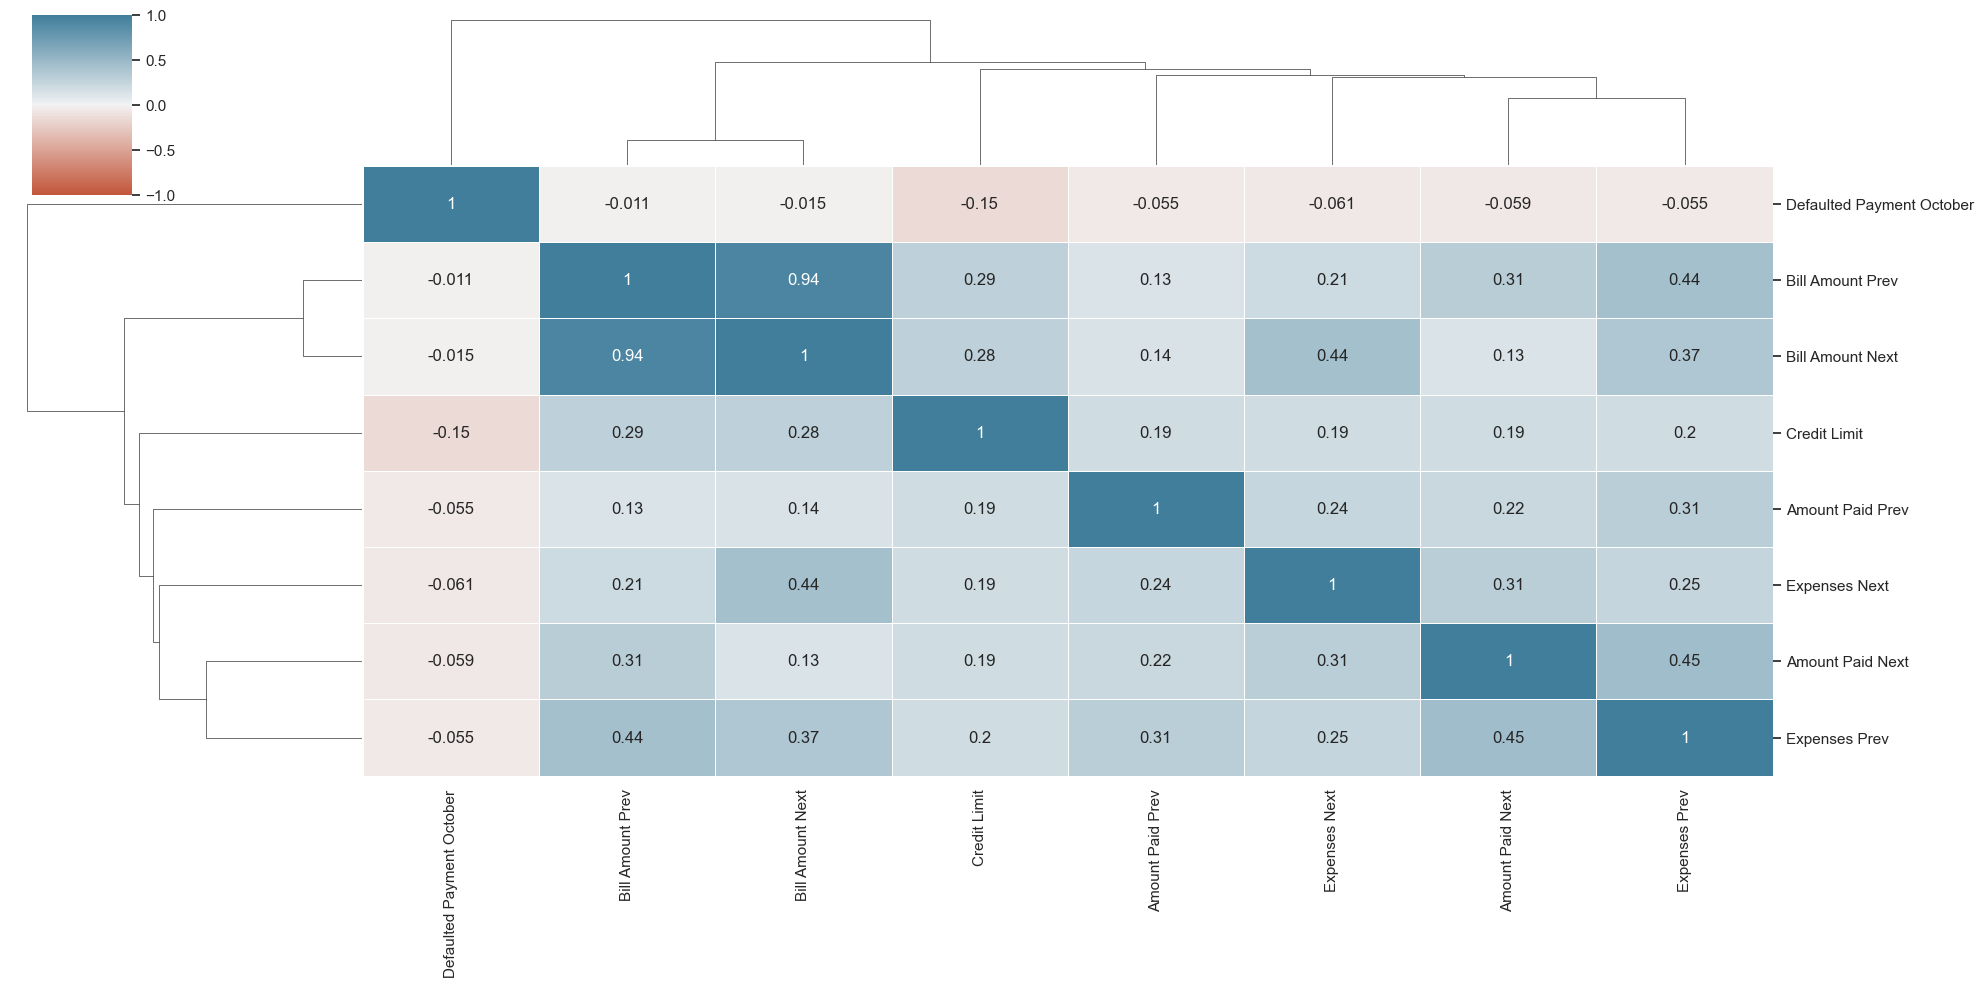

In [212]:
temp_df = time_df.copy().drop(columns=['Month Prev', 'Month Next', 'Sex', 'Education', 'Marriage', 'Age', 'Payed Status Prev', 'Payed Status Next'])
temp_df['Defaulted Payment October'] = temp_df['Defaulted Payment October'].map({ 'Not Defaulted': 0, 'Defaulted': 1 }).astype(int)
sns.clustermap(
    figsize=(20, 10),
    data=temp_df.corr(numeric_only=True),
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True
)

### Porcentaje de pagos a tiempo por mes

(0.0, 1.0)

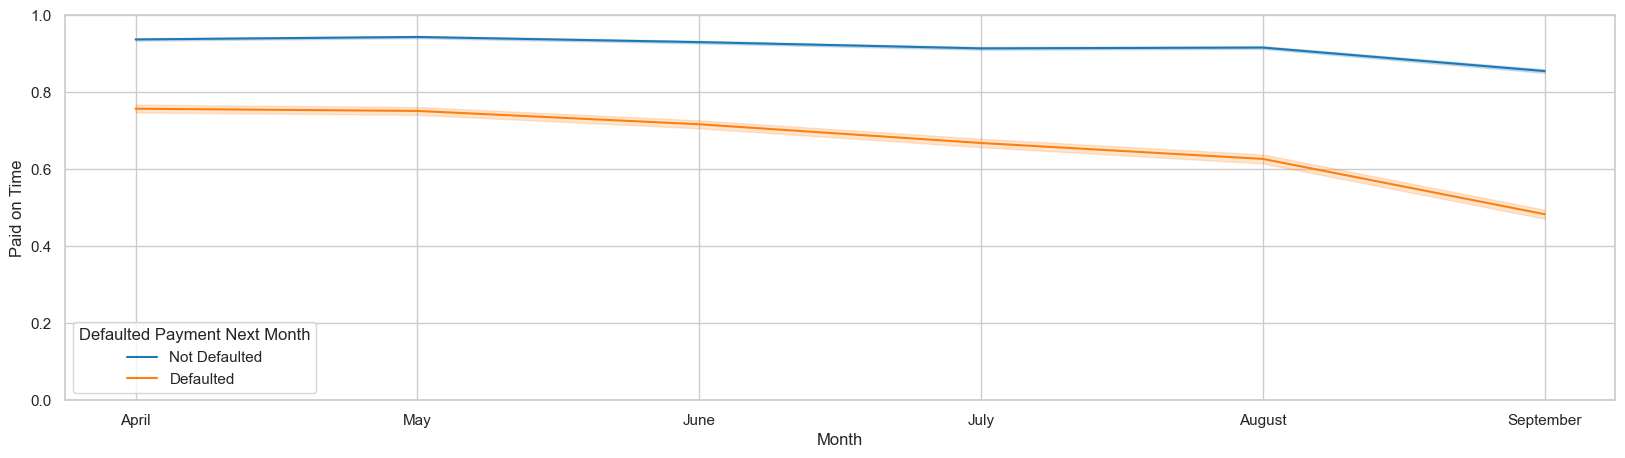

In [213]:
temp_df = df.copy()
payed_status_columns = ['Payed Status in September', 'Payed Status in August', 'Payed Status in July', 'Payed Status in June', 'Payed Status in May', 'Payed Status in April'][::-1]
for column in payed_status_columns:
    temp_df[column] = temp_df[column].map({
        'New Customer': 1,
        'Paid ahead': 1,
        'Paid on time': 1,
        'Delay 1 Month': 0,
        'Delay 2 Months': 0,
        'Delay 3 Months': 0,
        'Delay 4 Months': 0,
        'Delay 5 Months': 0,
        'Delay 6 Months': 0,
        'Delay 7 Months': 0,
        'Delay 8 Months': 0,
        'Delay 9+ Months': 0,
    })
temp_df = temp_df.rename(columns={column: column.replace('Payed Status in ', '') for column in payed_status_columns})
temp_df = temp_df.melt(
    id_vars=['Defaulted Payment Next Month'],
    value_vars = ['April', 'May', 'June', 'July', 'August', 'September'],
    var_name='Month',
    value_name='Paid on Time'
)
plt.figure(figsize=(20, 5))
sns.lineplot(
    x='Month',
    y='Paid on Time',
    hue='Defaulted Payment Next Month',
    data=temp_df
)
plt.ylim(0, 1)

### Predicción de default dado el pago en el mes anterior

Text(0.5, 1.0, 'Average Payment Behavior for Not Defaulted Customers')

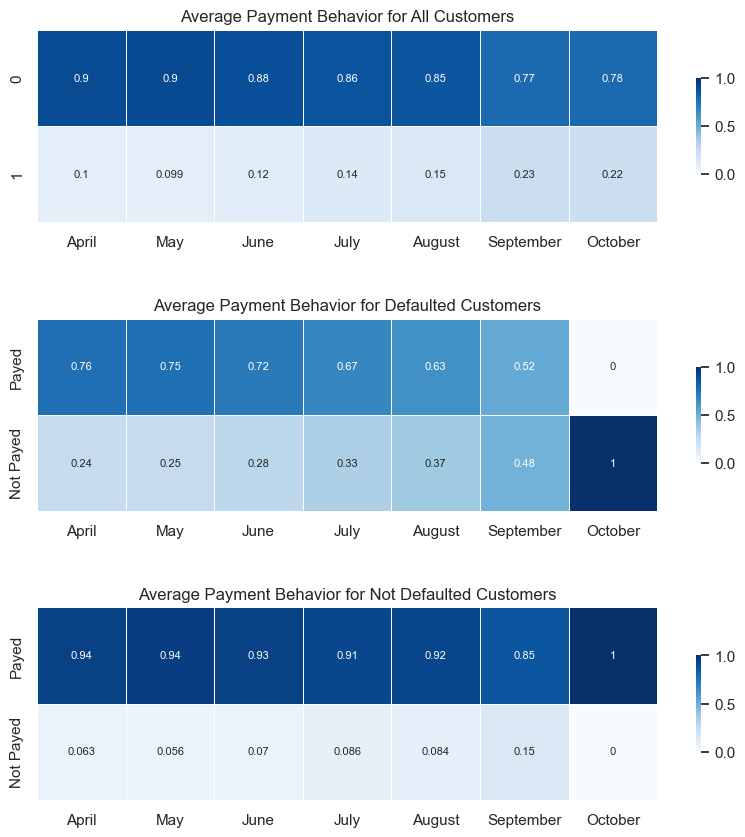

In [214]:
temp_df = df.copy()
payed_status_columns = ['Payed Status in September', 'Payed Status in August', 'Payed Status in July', 'Payed Status in June', 'Payed Status in May', 'Payed Status in April'][::-1]
for column in payed_status_columns:
    temp_df[column] = temp_df[column].map({
        'New Customer': 1,
        'Paid ahead': 1,
        'Paid on time': 1,
        'Delay 1 Month': 0,
        'Delay 2 Months': 0,
        'Delay 3 Months': 0,
        'Delay 4 Months': 0,
        'Delay 5 Months': 0,
        'Delay 6 Months': 0,
        'Delay 7 Months': 0,
        'Delay 8 Months': 0,
        'Delay 9+ Months': 0,
    })
temp_df['October'] = temp_df['Defaulted Payment Next Month'].map({ 'Not Defaulted': 1, 'Defaulted': 0 }).astype(int)
temp_df = temp_df.rename(columns={column: column.replace('Payed Status in ', '') for column in payed_status_columns})
temp_df = temp_df[['April', 'May', 'June', 'July', 'August', 'September', 'October']]

defaulted_df = temp_df[temp_df['October'] == 0]
defaulted_df = pd.DataFrame({
    'April': defaulted_df['April'].value_counts(normalize=True).values,
    'May': defaulted_df['May'].value_counts(normalize=True).values,
    'June': defaulted_df['June'].value_counts(normalize=True).values,
    'July': defaulted_df['July'].value_counts(normalize=True).values,
    'August': defaulted_df['August'].value_counts(normalize=True).values,
    'September': defaulted_df['September'].value_counts(normalize=True).values,
    'October': [0, 1],
}, index=['Payed', 'Not Payed'])

not_defaulted_df = temp_df[temp_df['October'] == 1]
not_defaulted_df = pd.DataFrame({
    'April': not_defaulted_df['April'].value_counts(normalize=True).values,
    'May': not_defaulted_df['May'].value_counts(normalize=True).values,
    'June': not_defaulted_df['June'].value_counts(normalize=True).values,
    'July': not_defaulted_df['July'].value_counts(normalize=True).values,
    'August': not_defaulted_df['August'].value_counts(normalize=True).values,
    'September': not_defaulted_df['September'].value_counts(normalize=True).values,
    'October': [1, 0],
}, index=['Payed', 'Not Payed'])

temp_df = pd.DataFrame({
    'April': temp_df['April'].value_counts(normalize=True).values,
    'May': temp_df['May'].value_counts(normalize=True).values,
    'June': temp_df['June'].value_counts(normalize=True).values,
    'July': temp_df['July'].value_counts(normalize=True).values,
    'August': temp_df['August'].value_counts(normalize=True).values,
    'September': temp_df['September'].value_counts(normalize=True).values,
    'October': temp_df['October'].value_counts(normalize=True).values,
})

plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.subplot(3, 1, 1)
sns.heatmap(
    data=temp_df,
    cmap=sns.color_palette("Blues", as_cmap=True),
    center=0.5,
    vmin=0,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    annot_kws={"size": 8}
)
plt.title("Average Payment Behavior for All Customers")
plt.subplot(3, 1, 2)
sns.heatmap(
    data=defaulted_df,
    cmap=sns.color_palette("Blues", as_cmap=True),
    center=0.5,
    vmin=0,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    annot_kws={"size": 8}
)
plt.title("Average Payment Behavior for Defaulted Customers")
plt.subplot(3, 1, 3)
sns.heatmap(
    data=not_defaulted_df,
    cmap=sns.color_palette("Blues", as_cmap=True),
    center=0.5,
    vmin=0,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    annot_kws={"size": 8}
)
plt.title("Average Payment Behavior for Not Defaulted Customers")

<Axes: >

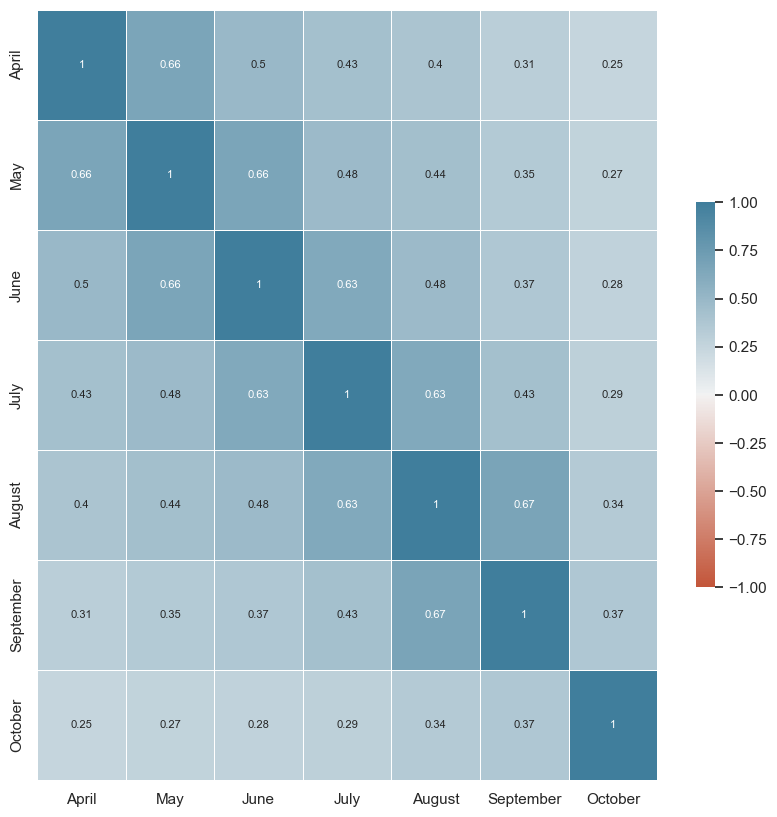

In [215]:
temp_df = df.copy()
payed_status_columns = ['Payed Status in September', 'Payed Status in August', 'Payed Status in July', 'Payed Status in June', 'Payed Status in May', 'Payed Status in April'][::-1]
for column in payed_status_columns:
    temp_df[column] = temp_df[column].map({
        'New Customer': 1,
        'Paid ahead': 1,
        'Paid on time': 1,
        'Delay 1 Month': 0,
        'Delay 2 Months': 0,
        'Delay 3 Months': 0,
        'Delay 4 Months': 0,
        'Delay 5 Months': 0,
        'Delay 6 Months': 0,
        'Delay 7 Months': 0,
        'Delay 8 Months': 0,
        'Delay 9+ Months': 0,
    })
temp_df['October'] = temp_df['Defaulted Payment Next Month'].map({ 'Not Defaulted': 1, 'Defaulted': 0 }).astype(int)
temp_df = temp_df.rename(columns={column: column.replace('Payed Status in ', '') for column in payed_status_columns})
temp_df = temp_df[['April', 'May', 'June', 'July', 'August', 'September', 'October']]
plt.figure(figsize=(10, 10))
sns.heatmap(
    data=temp_df.corr(),
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    annot_kws={"size": 8}
)

### Agregados de los últimos 6 meses

In [216]:
temp_df = df.copy()
payed_status_columns = ['Payed Status in September', 'Payed Status in August', 'Payed Status in July', 'Payed Status in June', 'Payed Status in May', 'Payed Status in April'][::-1]
for column in payed_status_columns:
    temp_df[column] = temp_df[column].map({
        'New Customer': 0,
        'Paid ahead': 0,
        'Paid on time': 0,
        'Delay 1 Month': 1,
        'Delay 2 Months': 1,
        'Delay 3 Months': 1,
        'Delay 4 Months': 1,
        'Delay 5 Months': 1,
        'Delay 6 Months': 1,
        'Delay 7 Months': 1,
        'Delay 8 Months': 1,
        'Delay 9+ Months': 1,
    }).astype(int)
temp_df['Defaulted Payment in October'] = temp_df['Defaulted Payment Next Month'].map({ 'Not Defaulted': 0, 'Defaulted': 1 }).astype(int)

temp_df['Expenses per Month'] = temp_df[['Expenses in May', 'Expenses in June', 'Expenses in July', 'Expenses in August', 'Expenses in September']].mean(axis=1)
temp_df['Amount Paid per Month'] = temp_df[['Amount Paid in April', 'Amount Paid in May', 'Amount Paid in June', 'Amount Paid in July', 'Amount Paid in August', 'Amount Paid in September']].mean(axis=1)
temp_df['Bill Amount per Month'] = temp_df[['Bill Amount in April', 'Bill Amount in May', 'Bill Amount in June', 'Bill Amount in July', 'Bill Amount in August', 'Bill Amount in September']].mean(axis=1)
temp_df['Number of Months with Delay'] = temp_df[['Payed Status in April', 'Payed Status in May', 'Payed Status in June', 'Payed Status in July', 'Payed Status in August', 'Payed Status in September']].sum(axis=1)
temp_df = temp_df[['Expenses per Month', 'Amount Paid per Month', 'Bill Amount per Month', 'Number of Months with Delay', 'Defaulted Payment in October']]
temp_df

,Expenses per Month,Amount Paid per Month,Bill Amount per Month,Number of Months with Delay,Defaulted Payment in October
ID,,,,,
1,920.4,114.833333,1284.000000,2,1
2,484.2,833.333333,2846.166667,2,1
3,3941.6,1836.333333,16942.166667,0,0
4,4966.2,1398.000000,38555.666667,0,0
5,9571.2,9841.500000,18223.166667,0,0
...,...,...,...,...,...
29996,42903.6,7091.666667,120891.500000,0,0
29997,3234.6,2415.000000,3530.333333,0,0
29998,2481.6,5216.666667,11749.333333,3,1


In [217]:
(
    smf.ols(
        formula='Q("Defaulted Payment in October") ~ Q("Expenses per Month") + Q("Amount Paid per Month") + Q("Bill Amount per Month") + Q("Number of Months with Delay")',
        data=temp_df
    )
    .fit()
    .summary()
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     Q("Defaulted Payment in October")   R-squared:                       0.161
Model:                                           OLS   Adj. R-squared:                  0.161
Method:                                Least Squares   F-statistic:                     1443.
Date:                               Wed, 08 May 2024   Prob (F-statistic):               0.00
Time:                                       23:52:44   Log-Likelihood:                -13547.
No. Observations:                              30000   AIC:                         2.710e+04
Df Residuals:                                  29995   BIC:                         2.715e+04
Df Model:                                          4                                         
Covariance Type:                           nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.1435      0.003     46.719      0.000       0.138       0.150
Q("Expenses per Month")            6.36e-07   2.76e-07      2.306      0.021    9.54e-08    1.18e-06
Q("Amount Paid per Month")       -2.609e-06   3.25e-07     -8.026      0.000   -3.25e-06   -1.97e-06
Q("Bill Amount per Month")       -2.131e-08   4.03e-08     -0.530      0.596      -1e-07    5.76e-08
Q("Number of Months with Delay")     0.1051      0.001     72.908      0.000       0.102       0.108
==============================================================================
Omnibus:                     4844.672   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7535.511
Skew:                           1.198   Prob(JB):                         0.00
Kurtosis:                       3.534   Cond. No.                     1.13e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

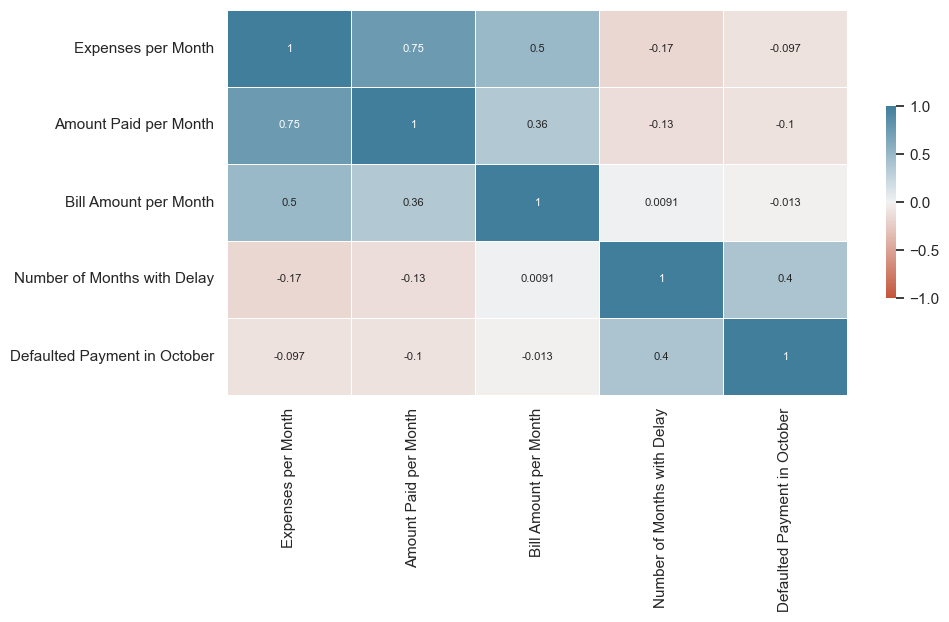

In [218]:
plt.figure(figsize=(10, 5))
sns.heatmap(
    data=temp_df.corr(),
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    annot_kws={"size": 8}
)

<Axes: xlabel='Number of Months with Delay', ylabel='Defaulted Payment in October'>

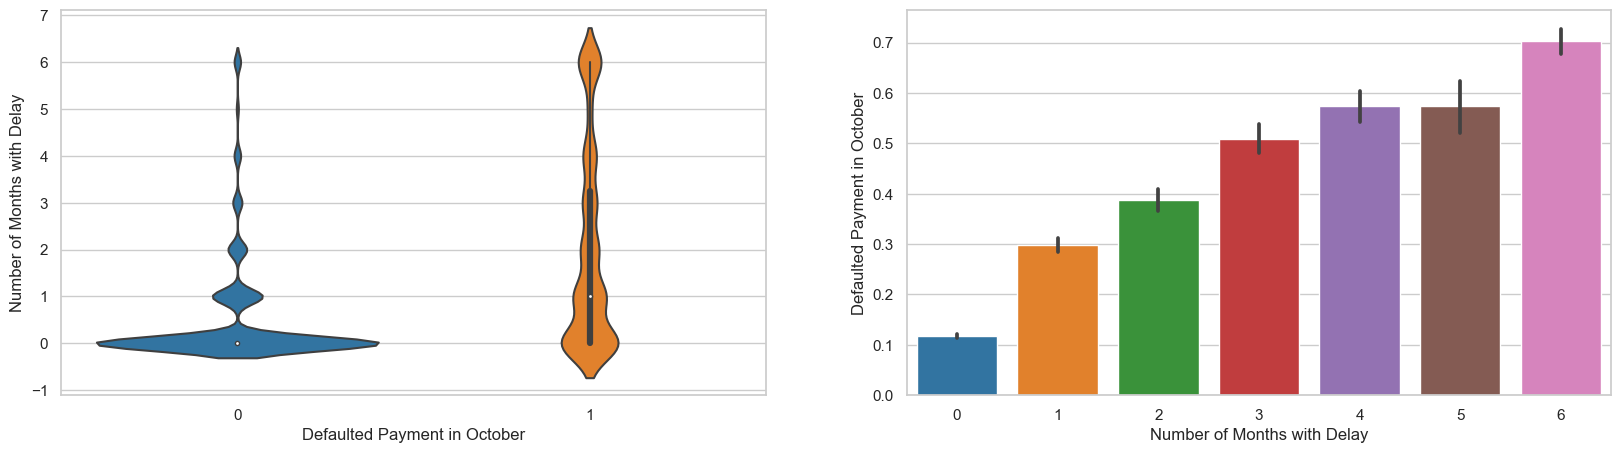

In [219]:
plt.figure(figsize=(20, 5))
plt.subplots_adjust(hspace=0.5)
plt.subplot(1, 2, 1)
sns.violinplot(
    x='Defaulted Payment in October',
    y='Number of Months with Delay',
    data=temp_df,
)
plt.subplot(1, 2, 2)
sns.barplot(
    x='Number of Months with Delay',
    y='Defaulted Payment in October',
    data=temp_df,
)

### Conclusiones

* El Bill Amount tiene una autocorrelación muy alta (94%)!
* Existe una particular correlación entre atrasarse 2 meses en algún momento y no pagar en el mes de Octubre (target).
* A mayor cantidad de meses atrasados, mayor probabilidad de no pagar en el mes actual.
* Personas que pagan a tiempo en el mes anterior tienen una tendencia a pagar a tiempo en el mes actual.
* Los clientes nuevos (sin historial de Paid Amount) tienen la tendencia de pagar a tiempo. También los clientes que no tienen deuda en el mes anterior (duh).

## Gráficas para el Dashboard

### Treemap para explorar datos demográficos

In [220]:
temp_df = df.copy()
temp_df['Age'] = pd.cut(
    temp_df['Age'], 
    bins=[20, 28, 35, 46, 80],
    labels=['Young Adult (20-27)', 'Adult (28-35)', 'Middle Aged (36-45)', 'Senior (46-80)'],
    include_lowest=True,
    ordered=True
)
temp_df['Defaulted Payment Next Month'] = temp_df['Defaulted Payment Next Month'].map({ 'Not Defaulted': 0, 'Defaulted': 1 }).astype(int)
mean_defaulted = temp_df['Defaulted Payment Next Month'].mean()
temp_df = temp_df.groupby(['Marriage', 'Sex', 'Age', 'Education'])['Defaulted Payment Next Month'].agg(['mean', 'count']).reset_index().rename(columns={'mean': 'Defaulted (%)', 'count': 'Number of Customers'})
temp_df = temp_df[temp_df['Marriage'] != 'Others']
temp_df = temp_df[temp_df['Education'] != 'Others']
temp_df['Defaulted (%)'] = temp_df['Defaulted (%)'] * 100
fig = px.treemap(
    temp_df, 
    path=[px.Constant("Customers"), 'Marriage', 'Sex', 'Age', 'Education'], 
    values='Number of Customers',
    color='Defaulted (%)', 
    color_continuous_scale="RdBu_r",
    color_continuous_midpoint=mean_defaulted * 100,
)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

### Parallel Coordinates para explorar el historial de pagos

In [238]:
temp_df = df.copy()
temp_df['Defaulted October Payment'] = temp_df['Defaulted Payment Next Month'].map({ 'Not Defaulted': 0, 'Defaulted': 1 }).astype(int)
for column in ['Payed Status in September', 'Payed Status in August', 'Payed Status in July', 'Payed Status in June', 'Payed Status in May', 'Payed Status in April']:
    temp_df[column] = temp_df[column].map({
        'New Customer': 0,
        'Paid ahead': 0,
        'Paid on time': 0,
        'Delay 1 Month': 1,
        'Delay 2 Months': 1,
        'Delay 3 Months': 1,
        'Delay 4 Months': 1,
        'Delay 5 Months': 1,
        'Delay 6 Months': 1,
        'Delay 7 Months': 1,
        'Delay 8 Months': 1,
        'Delay 9+ Months': 1,
    }).astype(int)
    temp_df[column] = temp_df[column] + np.random.normal(0, 0.1, temp_df.shape[0])
temp_df = temp_df.sample(500)
fig = go.Figure(
    data=go.Parcoords(
        line = dict(
            color = temp_df['Defaulted October Payment'],
            colorscale = 'RdBu_r',
            showscale = False,
            cmin = -1,
            cmax = 2,
        ),
        dimensions = list([
            dict(label = "April", values = temp_df['Payed Status in April'], tickvals=[0, 1], ticktext=['Paid on Time', 'Delayed']),
            dict(label = "May", values = temp_df['Payed Status in May'], tickvals=[0, 1], ticktext=['Paid on Time', 'Delayed']),
            dict(label = "June", values = temp_df['Payed Status in June'], tickvals=[0, 1], ticktext=['Paid on Time', 'Delayed']),
            dict(label = "July", values = temp_df['Payed Status in July'], tickvals=[0, 1], ticktext=['Paid on Time', 'Delayed']),
            dict(label = "August", values = temp_df['Payed Status in August'], tickvals=[0, 1], ticktext=['Paid on Time', 'Delayed']),
            dict(label = "September", values = temp_df['Payed Status in September'], tickvals=[0, 1], ticktext=['Paid on Time', 'Delayed']),
            dict(label = "Defaulted October Payment", values = temp_df['Defaulted October Payment'], tickvals=[0, 1], ticktext=['Not Defaulted', 'Defaulted']),
        ]),
        unselected = dict(line = dict(opacity = 0)),
    )
)

fig.show()

### KPI para mostrar el revenue esperado en la situación actual

In [316]:
p = 0.05  # Margen de ganancia promedio (profit margin)
r = 0.3  # Tasa de recuperación de catera (recovery rate)
temp_df = df.copy()
temp_df['Defaulted October Payment'] = temp_df['Defaulted Payment Next Month'].map({ 'Not Defaulted': 0, 'Defaulted': 1 }).astype(int)
temp_df['Average Bill Amount'] = temp_df[['Bill Amount in April', 'Bill Amount in May', 'Bill Amount in June', 'Bill Amount in July', 'Bill Amount in August', 'Bill Amount in September']].median(axis=1)
temp_df['Average Amount Paid'] = temp_df[['Amount Paid in April', 'Amount Paid in May', 'Amount Paid in June', 'Amount Paid in July', 'Amount Paid in August', 'Amount Paid in September']].median(axis=1)
temp_df['Average Debt'] = temp_df['Average Bill Amount'] - temp_df['Average Amount Paid']
temp_df['Income'] = temp_df['Average Bill Amount'] * 6 * p * (1 - temp_df['Defaulted October Payment'])
temp_df['Loses'] = temp_df['Average Debt'] * temp_df['Defaulted October Payment'] * (1 - r)
temp_df['Revenue'] = temp_df['Income'] - temp_df['Loses']
income = temp_df['Income'].sum()
loses = temp_df['Loses'].sum()
revenue = temp_df['Revenue'].sum()
print(f"income={income:.0f}, loses={loses:.0f}, revenue={revenue:.0f}")

fig = go.Figure()
fig.add_trace(go.Indicator(
    mode = "number",
    value = income,
    number = {'prefix': "$", 'font': {'size': 50, 'color': '#3cb040'}},
    title = {"text": "Income"},
    domain = {'row': 0, 'column': 0},
    delta = {}
))
fig.add_trace(go.Indicator(
    mode = "number",
    value = loses,
    number = {'prefix': "$", 'font': {'size': 50, 'color': '#f06454'}},
    title = {"text": "Unpaid Debt"},
    domain = {'row': 1, 'column': 0},
))
fig.add_trace(go.Indicator(
    mode = "number",
    value = revenue,
    number = {'prefix': "$", 'font': {'size': 80, 'color': '#5eb4e6'}},
    title = {"text": "Revenue"},
    domain = {'row': 2, 'column': 0},
))
fig.update_layout(
    grid = {'rows': 3, 'columns': 1, 'ygap': 0.5},
    margin = dict(t=50, l=25, r=25, b=25),
)

income=311942278, loses=191118244, revenue=120824034
